# Colorization Network

## Imports

In [8]:
import os
import math
import random

import cv2

import PIL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

## Get image data

In [9]:
data_set_dir = './DataSetLAB'
image_paths = os.listdir(data_set_dir)
image_paths = [image_path for image_path in image_paths if image_path.endswith('.jpg')]
random.shuffle(image_paths)
image_data = [PIL.Image.open(os.path.join(data_set_dir, image_path)) for image_path in image_paths]

## Some Preprocessing

In [10]:
# Normalize images
transform_color = transforms.Compose([transforms.ToTensor()])
transform_gray = transforms.Compose([transforms.ToTensor(), transforms.Grayscale()])

transformed_image_data = []
for i, image in enumerate(image_data):
    transformed_image_data.append((transform_gray(image), transform_color(image)))

In [11]:
transformed_image_data[0][1].shape

torch.Size([3, 128, 128])

## Train/Test Split

In [12]:
batch_size = 4
test_size = 0.8
index_test = math.floor(len(image_data) * test_size)

# include both color and gray images
trainloader = torch.utils.data.DataLoader(transformed_image_data[:index_test], batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_image_data[index_test:], batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Plot some images

In [13]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float64')
    plt.imshow(npimg)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images_gray, images_color = dataiter.next()

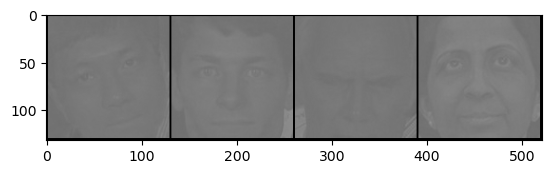

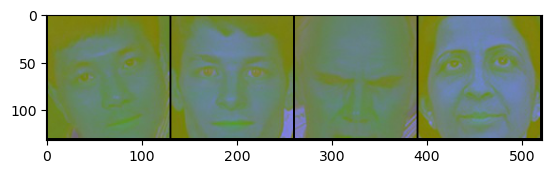

In [14]:
# show some images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

## Define network

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 3, 3, 2, 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, 2, 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, 2, 1),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(3, 3, 2, 2),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.ConvTranspose2d(3, 3, 2, 2),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.ConvTranspose2d(3, 3, 2, 2)
        )

    def forward(self, x):
        midlevel = self.downsample(x)
        output = self.upsample(midlevel)
        return output

net = Net()

### Move to cuda if possible

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


## Define optimizer

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0.0)

## Train

In [18]:
num_mini_batch_print = 50

for epoch in range(10):  # loop over the dataset multiple times
    print(f'----epoch: {epoch}')
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % num_mini_batch_print == num_mini_batch_print - 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_mini_batch_print))
            running_loss = 0.0

print('Finished Training')

----epoch: 0
[1,    50] loss: 0.080
[1,   100] loss: 0.011
[1,   150] loss: 0.011
----epoch: 1
[2,    50] loss: 0.010
[2,   100] loss: 0.009
[2,   150] loss: 0.008
----epoch: 2
[3,    50] loss: 0.007
[3,   100] loss: 0.006
[3,   150] loss: 0.006
----epoch: 3
[4,    50] loss: 0.005
[4,   100] loss: 0.005
[4,   150] loss: 0.005
----epoch: 4
[5,    50] loss: 0.005
[5,   100] loss: 0.005
[5,   150] loss: 0.004
----epoch: 5
[6,    50] loss: 0.004
[6,   100] loss: 0.005
[6,   150] loss: 0.004
----epoch: 6
[7,    50] loss: 0.004
[7,   100] loss: 0.005
[7,   150] loss: 0.004
----epoch: 7
[8,    50] loss: 0.004
[8,   100] loss: 0.004
[8,   150] loss: 0.004
----epoch: 8
[9,    50] loss: 0.004
[9,   100] loss: 0.004
[9,   150] loss: 0.004
----epoch: 9
[10,    50] loss: 0.004
[10,   100] loss: 0.004
[10,   150] loss: 0.004
Finished Training


## Save Model

In [19]:
PATH = './colorize_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model
### Peak at 4 test examples

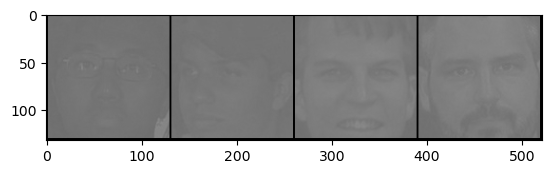

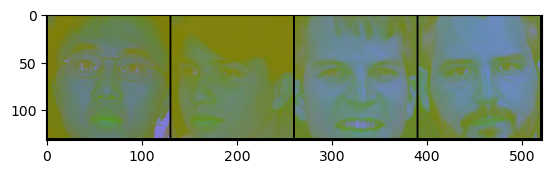

In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))

### Look at model performance on these examples

In [21]:
outputs = net(images.to(device))

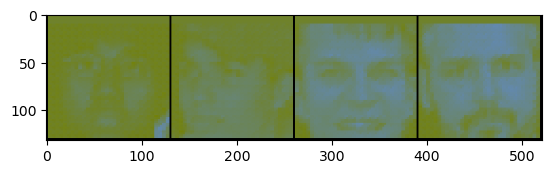

In [22]:
imshow(torchvision.utils.make_grid(outputs.cpu()))